In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals
from model_builder import (get_pinball_losses, get_simple_dist_model, get_simple_dense_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, save_object
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [4]:
def prepare_training(data, features, labels, available_cat_features, batch_size=1024):
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    
    # make batch creators
    labels = ['demand']
    def get_generators(batch_size=1024):
        train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                           batch_size=batch_size, check_nan=False)
        val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                         categorical_features=available_cat_features, batch_size=batch_size,
                                         check_nan=False)
        return train_batch_creator, val_batch_creator
    
    train_batch_creator, val_batch_creator = get_generators()
    
    # determine model input shape
    x, y = next(train_batch_creator.flow())
    INP_SHAPE = x[0].shape
    
    # make losses
    losses = get_pinball_losses()
    
    return train_batch_creator, val_batch_creator, get_generators, INP_SHAPE, losses

In [7]:
def perform_training_scheme(level, model, warmup_batch_size, finetune_batch_size,
                            warmup_lr_list=[1e-5, 1e-4, 1e-3, 2e-3, 3e-3, 1e-3],
                            finetune_lr_list=[2e-3, 3e-3, 1e-3, 3e-4, 1e-4],
                            warmup_epochs=10, finetune_epochs=10, model_name="stepped_lr", 
                            validation_steps=None, verbose=True):

    print("Starting level {}..".format(level)) if verbose else None
    
    # read data
    data, features, available_cat_features = read_and_preprocess_data(level=level)
    
    # setup for training
    batch_size = warmup_batch_size[level]
    train_batch_creator, val_batch_creator, get_generators, INP_SHAPE, losses = prepare_training(
        data, features, labels, available_cat_features, batch_size=batch_size)
    
    # compile model and initialize logger
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
    logger = Logger(val_batch_creator)
    
    # train model: warm-up
    lr_list = warmup_lr_list[0:3]
    
    for lr_block in warmup_lr_list:
        # set lr (without recompiling and losing momentum)
        def lr_scheduler(epoch, lr):
            return lr_block
        lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

        # train model
        val_steps = validation_steps if validation_steps is not None else val_batch_creator.__len__()
        history = model.fit(train_batch_creator.flow(), epochs=warmup_epochs, steps_per_epoch=100,
                            validation_data=val_batch_creator.flow(), validation_steps=val_steps,
                            callbacks=[lr_callback, logger])
    
    # evaluate
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    metrics1 = metrics
    
    # save warm-up result
    model.save_weights(model_dir + 'level{}_{}_part1_WSPL{:.2e}.h5'.format(level, model_name, metrics['WSPL']))
    
    # train model: continued
    lr_list = warmup_lr_list[3:6]
    for lr_block in lr_list:
        # set lr (without recompiling and losing momentum)
        def lr_scheduler(epoch, lr):
            return lr_block
        lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

        # train model
        val_steps = validation_steps if validation_steps is not None else val_batch_creator.__len__()
        history = model.fit(train_batch_creator.flow(), epochs=warmup_epochs, steps_per_epoch=100,
                            validation_data=val_batch_creator.flow(), validation_steps=val_steps,
                            callbacks=[lr_callback, logger])
    
    # evaluate
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    metrics2 = metrics
    
    # save continued result
    model.save_weights(model_dir + 'level{}_{}_part2_WSPL{:.2e}.h5'.format(level, model_name, metrics['WSPL']))
    
    # fine-tune
    batch_size = finetune_batch_size[level]
    train_batch_creator, val_batch_creator = get_generators(batch_size)
    
    lr_list = finetune_lr_list
    
    for lr_block in lr_list:
        # set lr (without recompiling and losing momentum)
        def lr_scheduler(epoch, lr):
            return lr_block
        lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

        # train model
        val_steps = validation_steps if validation_steps is not None else val_batch_creator.__len__()
        history = model.fit(train_batch_creator.flow(), epochs=finetune_epochs, steps_per_epoch=100,
                            validation_data=val_batch_creator.flow(), validation_steps=val_steps,
                            callbacks=[lr_callback, logger])
    
    # calculate WSPL and save metrics
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    metrics3 = metrics
    
    # save fine-tuned model
    model.save_weights(model_dir + 'level{}_{}_part3_WSPL{:.2e}.h5'.format(level, model_name, metrics['WSPL']))
    
    return model, logger, metrics1, metrics2, metrics3

# Train MLP - training scheme - multiple levels

In [5]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [6]:
model_dir = 'models/uncertainty/training_scheme/try1/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [8]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3255,),
}

# Set initial batch size
warmup_batch_size = {level: 64 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 256 if level <= 9 else 25000 for level in range(1, 1+12)}

# select which model function was used to build the model
models_base = {
    1: get_direct_dist_model(inp_shape=input_shapes[1], num_nodes=2, clear_session=False),
    2: get_direct_dist_model(inp_shape=input_shapes[2], num_nodes=2, clear_session=False),
    3: get_direct_dist_model(inp_shape=input_shapes[3], num_nodes=6, clear_session=False),
    4: get_direct_dist_model(inp_shape=input_shapes[4], num_nodes=6, clear_session=False),
    5: get_direct_dist_model(inp_shape=input_shapes[5], num_nodes=8, clear_session=False),
    6: get_direct_dist_model(inp_shape=input_shapes[6], num_nodes=8, clear_session=False),
    7: get_direct_dist_model(inp_shape=input_shapes[7], num_nodes=10, clear_session=False),
    8: get_direct_dist_model(inp_shape=input_shapes[8], num_nodes=10, clear_session=False),
    9: get_direct_dist_model(inp_shape=input_shapes[9], num_nodes=10, clear_session=False),
   10: get_direct_dist_model(inp_shape=input_shapes[10], num_nodes=256, clear_session=False),
   11: get_direct_dist_model(inp_shape=input_shapes[11], num_nodes=256, clear_session=False),
   12: get_direct_dist_model(inp_shape=input_shapes[12], num_nodes=512, clear_session=False),
}

## Baseline

I planned on investigating the training scheme due to the inconsistent performance of the level 1 model, but it turned out this was accidentally a Dist(2) model instead of a Direct(2) model. Switching this resulted in good performance (although slightly higher than the best Dist(2) model, 0.0645 versus 0.0556 - 0.1407 - 0.0791).

### Level 1

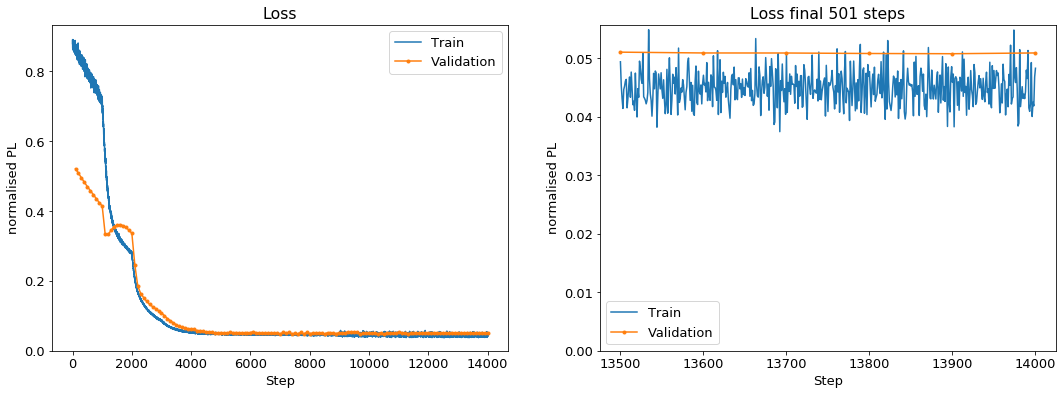

100/100 [==============================] - 3s 29ms/step - loss: 0.0450 - q0_loss: 5.6202e-04 - q1_loss: 0.0018 - q2_loss: 0.0064 - q3_loss: 0.0080 - q4_loss: 0.0100 - q5_loss: 0.0084 - q6_loss: 0.0069 - q7_loss: 0.0022 - q8_loss: 7.1754e-04 - val_loss: 0.0509 - val_q0_loss: 6.2775e-04 - val_q1_loss: 0.0016 - val_q2_loss: 0.0069 - val_q3_loss: 0.0089 - val_q4_loss: 0.0119 - val_q5_loss: 0.0099 - val_q6_loss: 0.0081 - val_q7_loss: 0.0024 - val_q8_loss: 6.2825e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{1: 0.06449894980481645, 'WSPL': 0.06449894980481645}


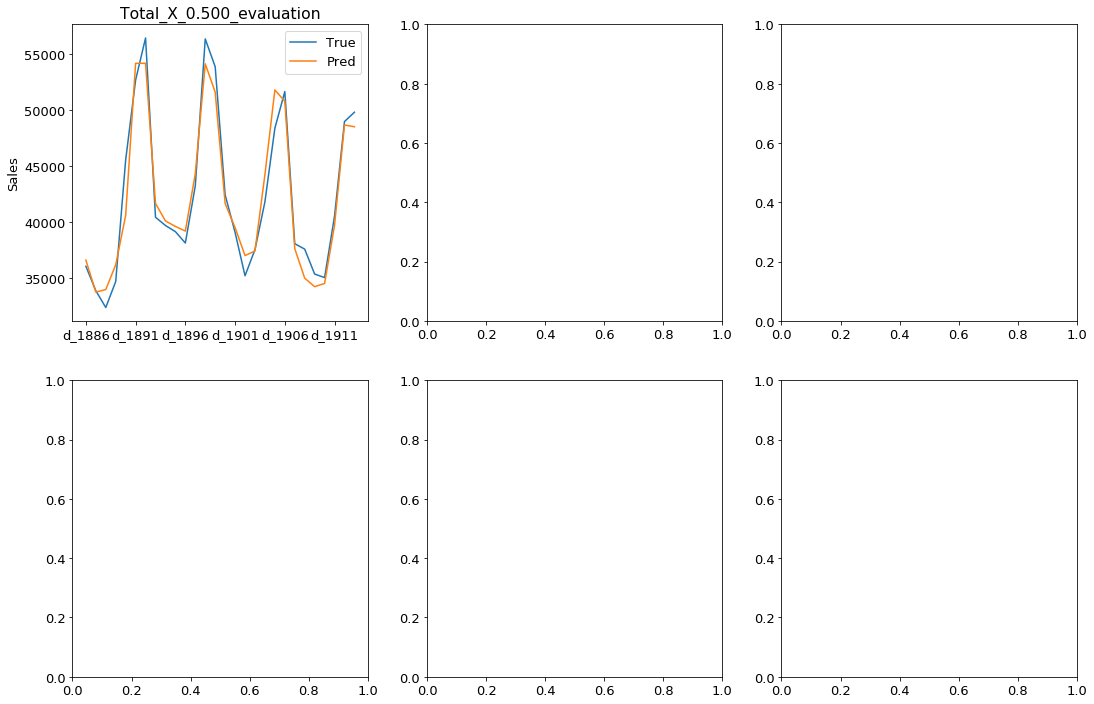

In [11]:
level = 1
model = models_base[level]

model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
    level, model, warmup_batch_size, finetune_batch_size)

### Level 3

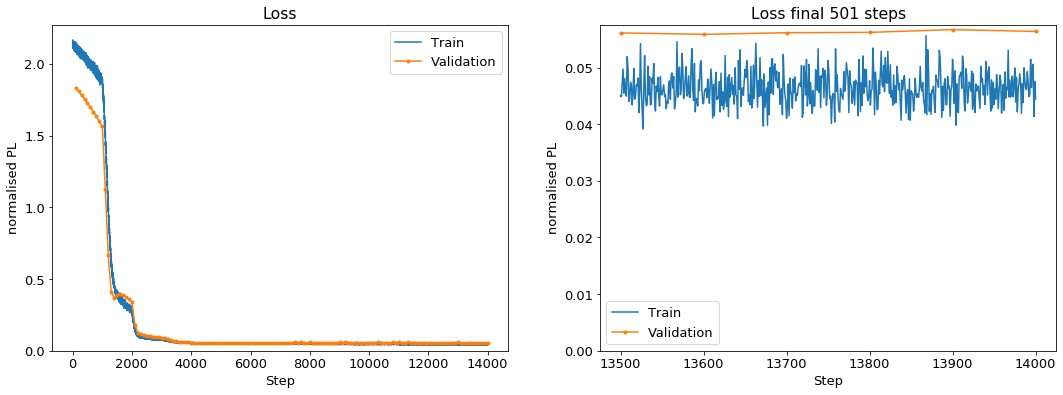

100/100 [==============================] - 3s 33ms/step - loss: 0.0464 - q0_loss: 4.9227e-04 - q1_loss: 0.0017 - q2_loss: 0.0066 - q3_loss: 0.0084 - q4_loss: 0.0107 - q5_loss: 0.0088 - q6_loss: 0.0071 - q7_loss: 0.0019 - q8_loss: 5.8377e-04 - val_loss: 0.0564 - val_q0_loss: 3.9628e-04 - val_q1_loss: 0.0017 - val_q2_loss: 0.0081 - val_q3_loss: 0.0104 - val_q4_loss: 0.0130 - val_q5_loss: 0.0109 - val_q6_loss: 0.0087 - val_q7_loss: 0.0024 - val_q8_loss: 8.5066e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.11119780603216071, 'WSPL': 0.11119780603216071}


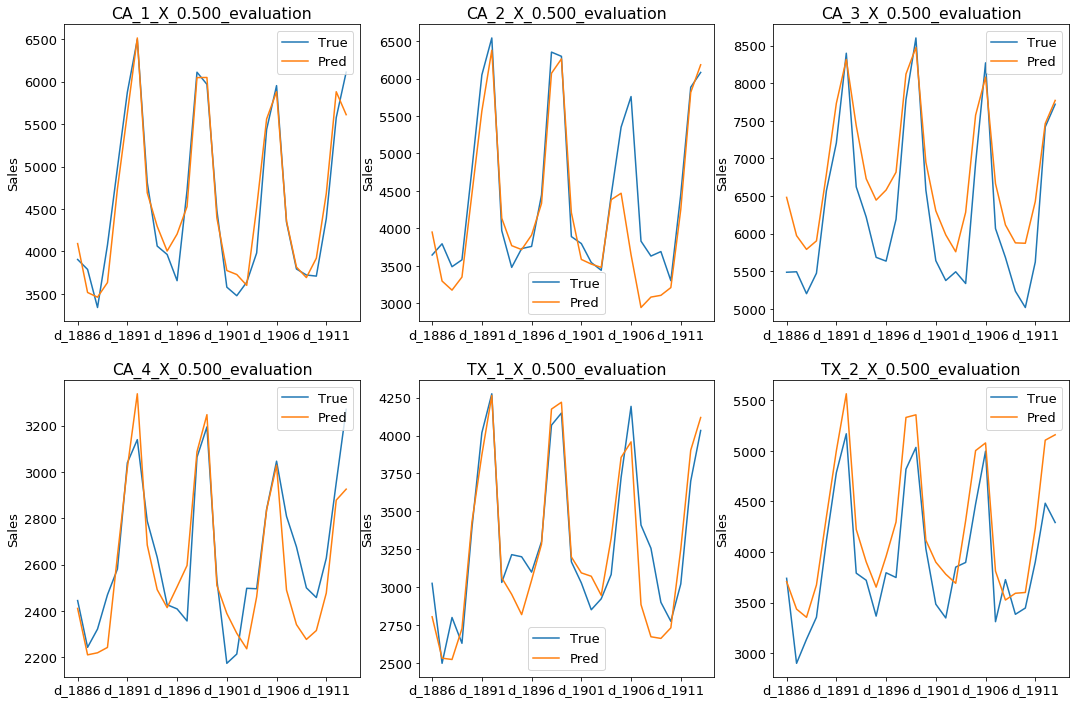

In [9]:
level = 3
model = get_direct_dist_model(inp_shape=input_shapes[3], num_nodes=6, clear_session=False)
model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
    level, model, warmup_batch_size, finetune_batch_size, model_name="nodes6")

In [10]:
metrics1, metrics2, metrics3

({3: 0.10493713581646556, 'WSPL': 0.10493713581646556},
 {3: 0.11419979612882548, 'WSPL': 0.11419979612882548},
 {3: 0.11119780603216071, 'WSPL': 0.11119780603216071})

### Level 12

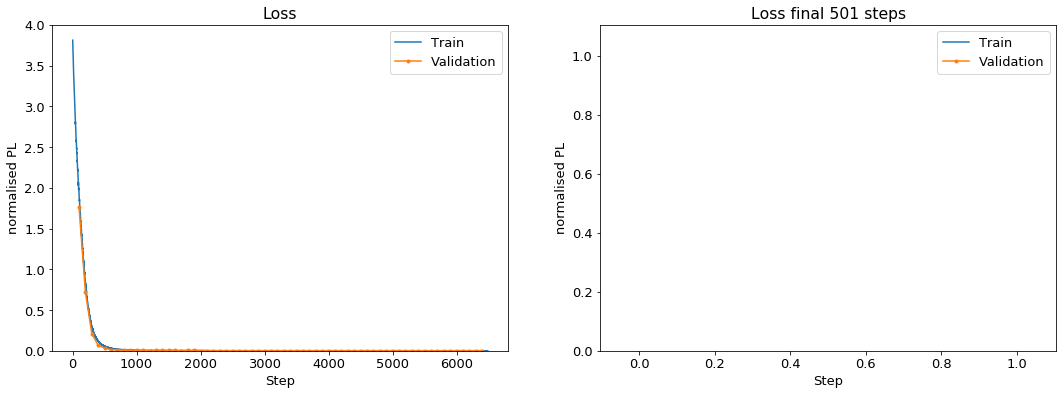

100/100 [==============================] - 373s 4s/step - loss: nan - q0_loss: nan - q1_loss: nan - q2_loss: nan - q3_loss: nan - q4_loss: nan - q5_loss: nan - q6_loss: nan - q7_loss: nan - q8_loss: nan - val_loss: nan - val_q0_loss: nan - val_q1_loss: nan - val_q2_loss: nan - val_q3_loss: nan - val_q4_loss: nan - val_q5_loss: nan - val_q6_loss: nan - val_q7_loss: nan - val_q8_loss: nan
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{12: nan, 'WSPL': nan}


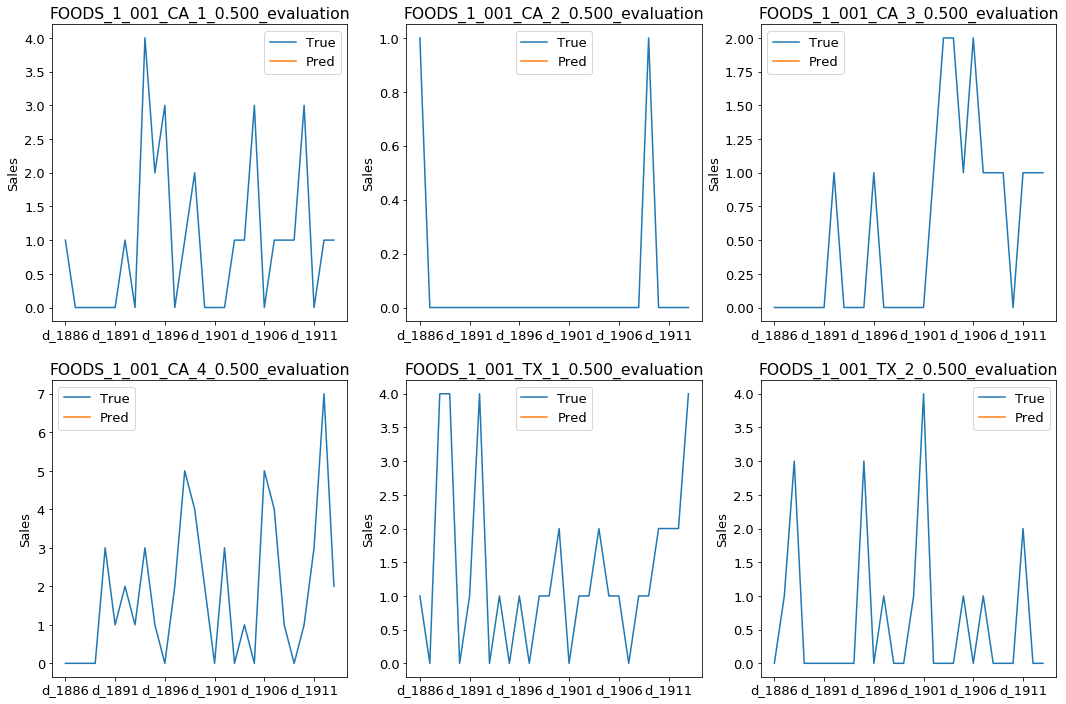

In [9]:
level = 12
model = models_base[level]

model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
    level, model, warmup_batch_size, finetune_batch_size, validation_steps=50)

In [10]:
metrics1, metrics2, metrics3

({12: 0.2579790704992638, 'WSPL': 0.2579790704992638},
 {12: nan, 'WSPL': nan},
 {12: nan, 'WSPL': nan})

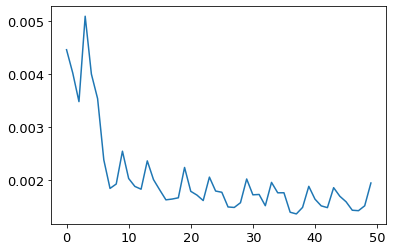

In [30]:
a = np.array(logger.val_metrics['val_loss'])
a = a[[elem > 0 for elem in a]]
plt.plot(a[-50:])

In [31]:
save_object(logger.train_metrics, model_dir + "metrics_train_level{}_baseline.pickle".format(level))
save_object(logger.val_metrics, model_dir + "metrics_val_level{}_baseline.pickle".format(level))

In [32]:
model.set_weights(logger.best_model)
model.save_weights(model_dir + "best_model_level12.h5")

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{12: 0.24721925067612105, 'WSPL': 0.24721925067612105}


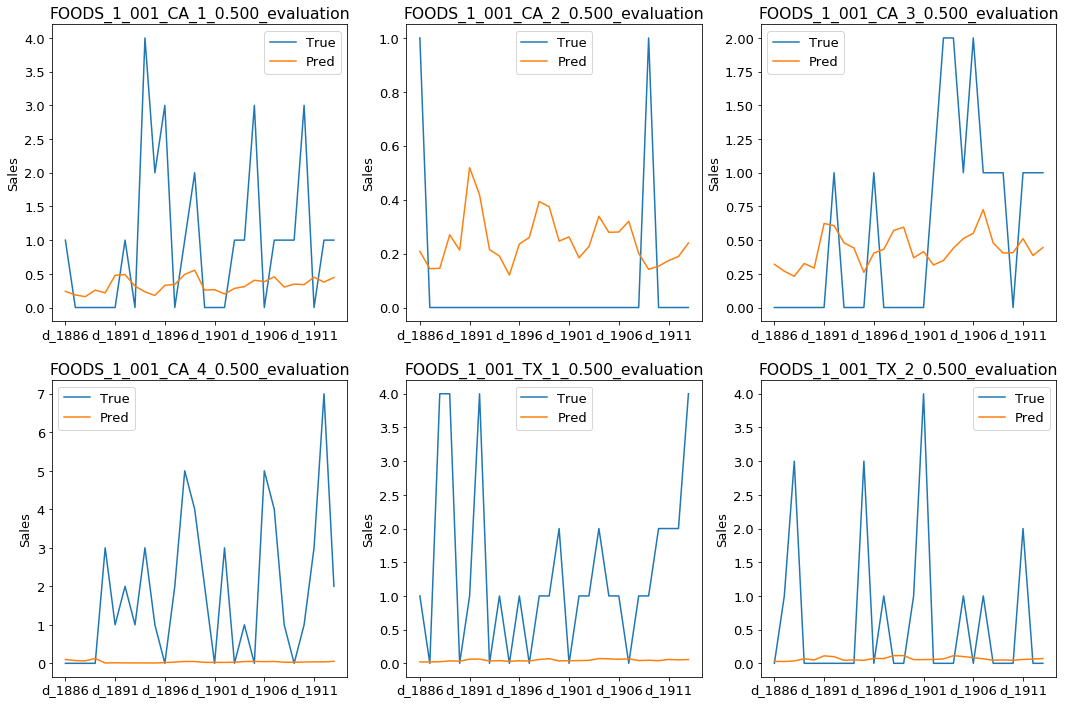

In [40]:
metrics, df = evaluate_model(model, ref, logger.val_batch_creator, calendar, quantiles, data_dir, level)

### Tweak training scheme

In [ ]:
level = 12
model = models_base[level]

model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
    level, model, warmup_batch_size, finetune_batch_size, validation_steps=50)